In [1]:
import numpy as np
import cvxpy as cvx

class hopping_tomography:

    def __init__( self, input_data, input_times, PNP_H = None, load = None, save = None ):
        """
        data_input: list of diagonal input correlations
        input_times: times at which input correlations are taken
        """
        self.input_data = input_data
        self.input_times = input_times
        self.nmb_times = len( input_times )
        if PNP_H is None:
            self.LL = input_data.shape(1)
            self.H = nearest_neighbor_hopping( self.L )
        else:
            self.H = PNP_H
        self.LL = self.H.L
    

    def recover_SDP(self):

        A = []
        G_t = []
        b_t = []
        for t_ind in range( self.nmb_times ):
            G_i = self.H.G( self.input_times[ t_ind ] )
            G_t.append(G_i)
            b_t.append(self.input_data[ t_ind ])

        Gamma = cvx.Variable( (self.LL, self.LL), complex = True)
        
        objective = cvx.Minimize( cvx.sum([ 
                    cvx.norm( (G_t[t] @ Gamma @ G_t[t].conj().T)[range(self.LL),range(self.LL)]
                                             - b_t[t] , 2 )  for t in range(self.nmb_times) ] ))

        Id = np.eye( self.LL )        
        constraints = [ Gamma >> 0, Id-Gamma >>0 ] 
        #constraints = constraints + [ Gamma[ self.ini_matrix_select_ind( self.LL ) ] == 0 ] 

        self.prob = cvx.Problem(objective, constraints)

        result = self.prob.solve(solver=cvx.SCS, eps=1e-5, verbose=True, max_iters = 2500)

        self.ReGamma = Gamma.value.real
        self.ImGamma = Gamma.value.imag
        self.Gamma = Gamma.value 
        self.chi2 = self.prob.value
        
        print("Final residue:", self.prob.value)
        print("Normalized residue /size/times ", self.prob.value/(self.nmb_times) )
        print("Reconstructed matrix\n", self.Gamma )
        
    def ini_matrix_select_ind( self, L ):
        x_ind = []
        y_ind = []
        for x in range( L ):
            for y in range( L ):
                if x % 2 == 0 and y % 2 == 0:
                    x_ind.append( x )
                    y_ind.append( y )
        return ( x_ind, y_ind )
        

In [2]:
from gaussian_fermions import *
L = 20
N_shots = 0#1e8
N = 15
T = 15
beta = 3
H_nnh = nearest_neighbor_hopping( L )
H_quench = nearest_neighbor_hopping( 2 * L )

cov_thermal = H_nnh.cov_thermal( beta )

cov_ini =  np.kron( cov_thermal, [ [ 0, 0 ], [ 0, 1 ] ] ) 

if N_shots != 0:
    sigma = 1. / np.sqrt( N_shots / N )
else:
    sigma = 0

times = np.linspace( 0, T, N )
data = [ H_quench.cov_evolve( cov_ini, t ).real.diagonal(0) + np.random.normal( 0, sigma, 2*L ) for t in times ]

tomography = hopping_tomography( data, times, H_quench )
tomography.recover_SDP()


----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 1806015
eps = 1.00e-05, alpha = 1.50, max_iters = 2500, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 3815, constraints m = 8895
Cones:	soc vars: 2415, soc blks: 615
	sd vars: 6480, sd blks: 2
Setup time: 3.60e+00s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 4.89e+20  4.18e+20  9.59e-01 -7.40e+21 -1.56e+20  5.50e+21  5.49e-02 
   100| 5.98e-05  5.19e-05  6.72e-06 -5.65e-06  1.07e-06  1.40e-16  3.77e+00 
   200| 1.94e-05  1.52e-05  1.54e-05 -5.78e-06  9.58e-06  9.21e-17  7.19e+00 
  

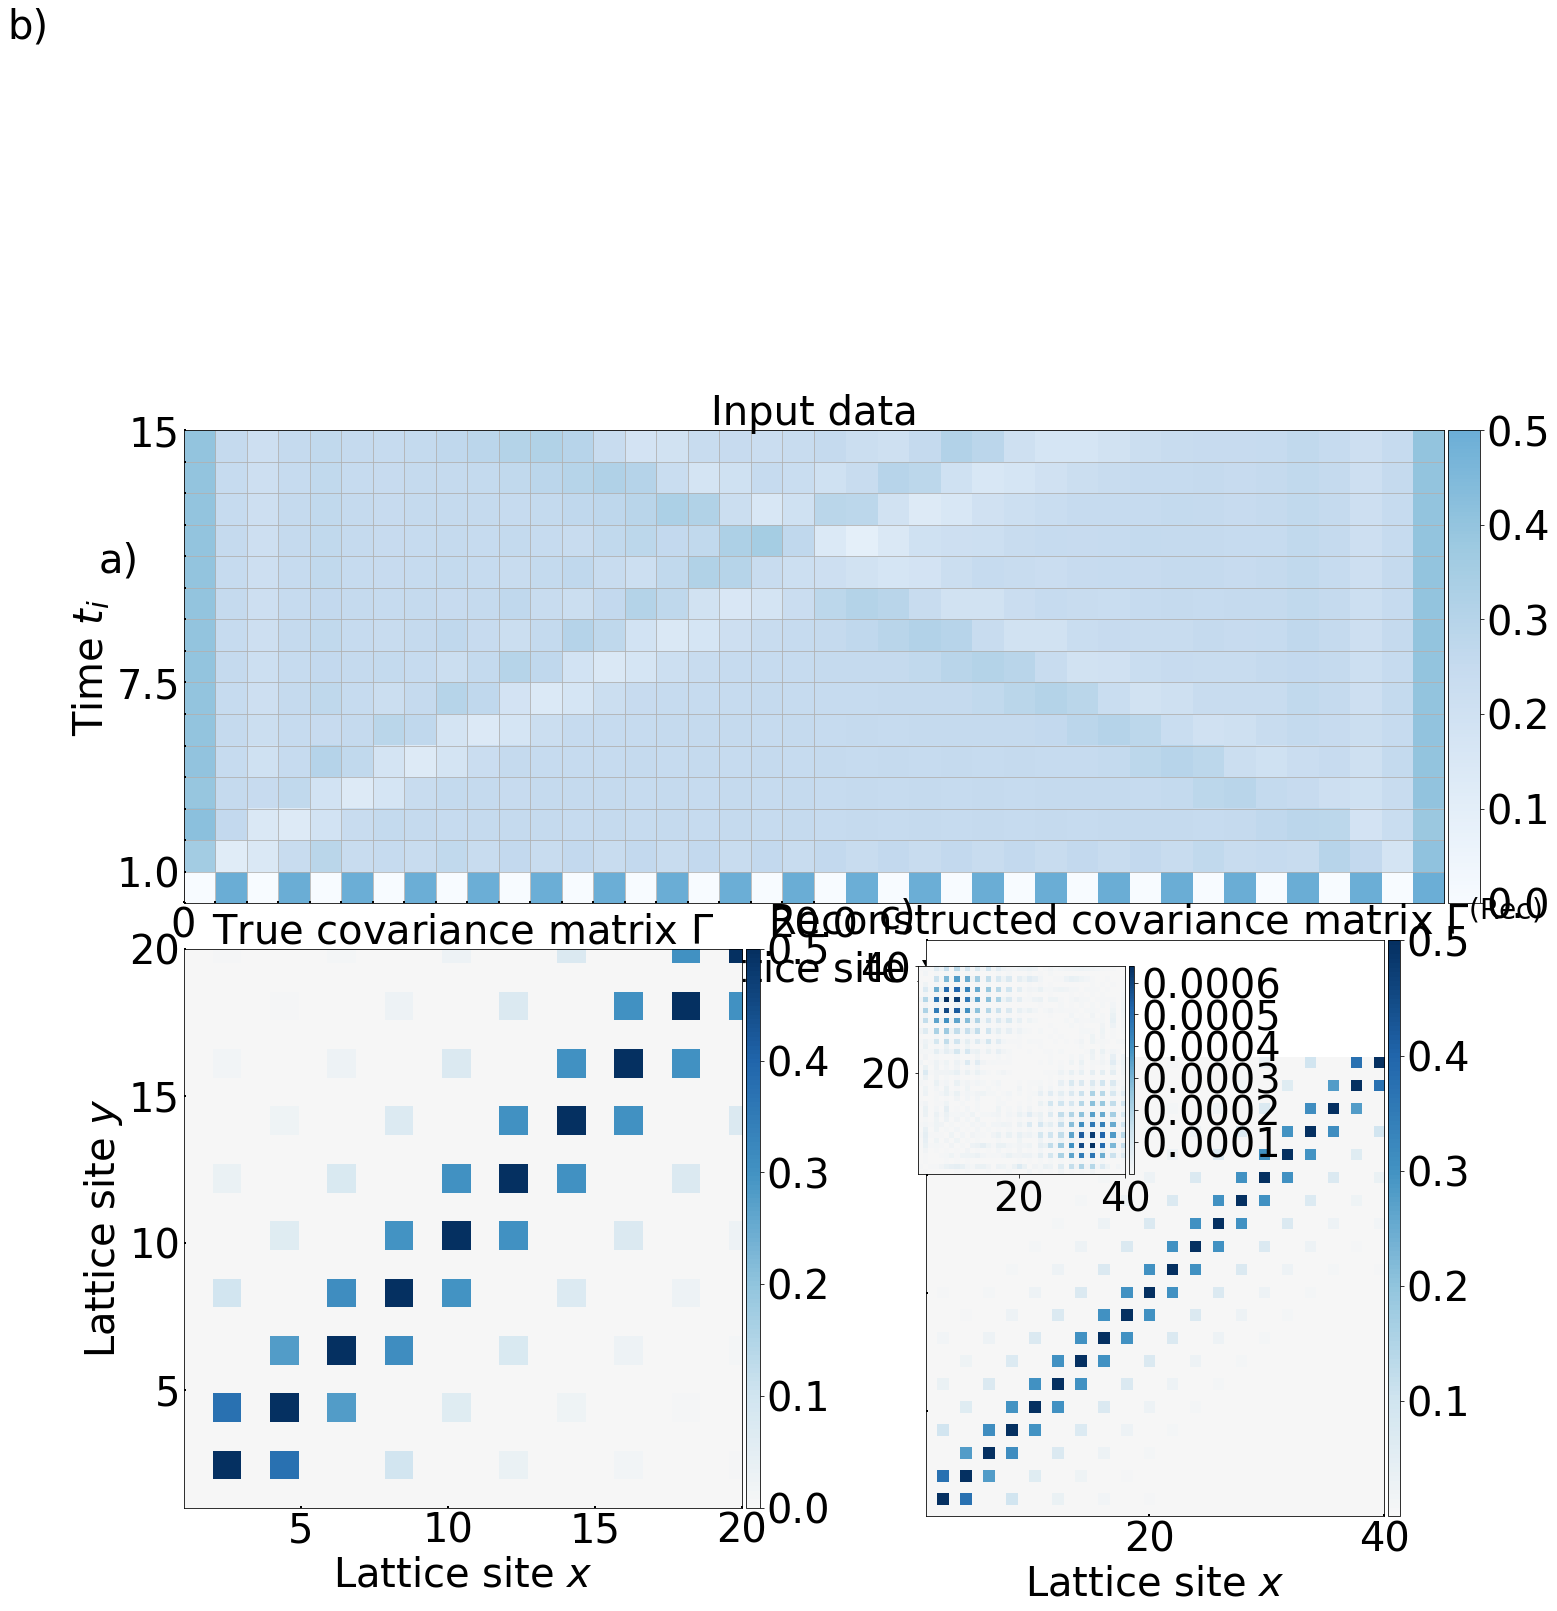

In [3]:
LL=2*L
save_path = 'figs/tomography_main_L_'+str(L)+'_T_'+str(T)+'_N_'+str(N)+'_sigma_'+str( int( np.ceil(sigma) ) )+'.pdf'

fontsize = 40
plt.rcParams['axes.labelsize'] = fontsize
plt.rcParams['axes.titlesize'] = fontsize
plt.rcParams['font.size'] = fontsize

#Main plot
fig = plt.figure( figsize = ( 20,20 ) )

data_pos_x  = 0.06
data_pos_y = .49
data_height = 0.4
data_width = 0.9

ini_pos_x  = 0.06
ini_pos_y = .1
ini_height = 0.4
ini_width = ini_height

rec_pos_x  = 0.54
rec_pos_y = .1
rec_height = 0.4
rec_width = rec_height

inset_pos_x = 0.57
inset_pos_y = 0.335   
inset_height = 0.15
inset_width = 0.15

label_a_x = -2.7
label_a_y = 10.5
label_b_x = -5
label_b_y = 51   
label_c_x = -3
label_c_y = 51

## a)
#Input data
ax_input_data = fig.add_axes( [ data_pos_x, data_pos_y, data_width, data_height ] )   


plt.text( label_a_x,label_a_y, 'a)')


im_input_data = ax_input_data.imshow( data, cmap='Blues', aspect = 'auto', interpolation = None, 
                                     extent= [0, LL, N, 0])

title = r'Input data'
plt.title( title )
plt.xlabel( 'Lattice site $x$' )
plt.ylabel( 'Time $t_i$' )
plt.clabel = r'$N_x(t)$'

plt.grid() 

plt.xlim((0,LL))
N = len( times )        
plt.ylim((0,N))

xlabels = ['']*(LL+1)
xlabels[0]='0'
xlabels[-1]=(LL)
xlabels[int(LL/2)] =(LL/2)
ylabels = ['']*(N+1)
ylabels[1]=T/N
ylabels[-1]=T
ylabels[int(N/2)]= ( (T/2))
#ylabels[5]= ( (T/2))

plt.xticks( range(0,L+1),xlabels )
plt.yticks( range(0,N+1), ylabels)

ax_input_data.tick_params(direction='in', length=2, width=2, colors='k')#,    grid_color='k', grid_alpha=0.5)

divider = make_axes_locatable(ax_input_data)
cax = divider.append_axes("right", size="2.5%", pad=0.05)        
cbar = plt.colorbar(im_input_data, cax=cax)
cbar.set_clim( 0, 1 )
ax_input_data.set_aspect(1)

## b)
#Plot cov_ini
ax_cov_ini = fig.add_axes( [ ini_pos_x, ini_pos_y, ini_width, ini_height ] )

im_cov_ini = ax_cov_ini.imshow( abs(cov_ini), cmap='RdBu', aspect='equal', interpolation = None, extent = [ 1, LL, LL, 1])
title = r'True covariance matrix $\Gamma$'
plt.title( title )
plt.text( label_b_x,label_b_y, 'b)')
plt.xlim((1,L))
plt.ylim((1,L))
plt.xlabel( 'Lattice site $x$' )
plt.ylabel( 'Lattice site $y$' )
ax_cov_ini.tick_params(direction='in', length=2, width=2, colors='k')
divider = make_axes_locatable(ax_cov_ini)
cax = divider.append_axes("right", size="2.5%", pad=0.05)

cbar = plt.colorbar(im_cov_ini, cax=cax)
range_plot = np.max( np.abs( cov_ini ) )
cbar.set_clim( -range_plot, range_plot )

## c)
#Plot cov reconstructed + inset deviation

ax_cov_rec = fig.add_axes( [ rec_pos_x, rec_pos_y, rec_width, rec_height ] )
cov_rec = abs(tomography.Gamma)
inset_cov = abs( cov_ini - tomography.Gamma )
im_cov_rec = ax_cov_rec.imshow( cov_rec, cmap='RdBu', aspect='equal', interpolation = None, extent = [ 1, LL, LL, 1])
plt.text( label_c_x,label_c_y, 'c)')

title = r'Reconstructed covariance matrix $\Gamma^{\rm(Rec)}$'
plt.title( title )
plt.xlim((1,LL))
plt.ylim((1,LL))
plt.xlabel( 'Lattice site $x$' )
ylabels = ['']*5
plt.yticks(range(10,51,10), ylabels)
ax_cov_rec.tick_params(direction='in', length=2, width=2, colors='k')

divider = make_axes_locatable( ax_cov_rec )
cax_cov_rec = divider.append_axes("right", size="2.5%", pad=0.05)

cbar = plt.colorbar( im_cov_rec, cax = cax_cov_rec )
range_plot = np.max( np.abs( cov_rec ) )
cbar.set_clim( -range_plot, range_plot )

#inset 
inset = fig.add_axes( [ inset_pos_x, inset_pos_y, inset_width, inset_height ] )
im2 = inset.imshow( inset_cov, extent = [ 1, LL, LL, 1], cmap='RdBu', aspect='equal', interpolation = None)
plt.xlim((1,LL))
plt.ylim((1,LL))
divider2 = make_axes_locatable(inset)
cax_cov_rec2 = divider2.append_axes("right", size="2.5%", pad=0.05)
cbar2 = plt.colorbar(im2, cax = cax_cov_rec2 )
range_plot = np.max( np.abs( inset_cov ) )
cbar2.set_clim( -range_plot, range_plot )


plt.savefig( save_path, format='pdf')
plt.show()


In [4]:
data2 = [ H_quench.cov_evolve( tomography.Gamma, t ).real.diagonal(0) 
         -H_quench.cov_evolve( cov_ini, t ).real.diagonal(0)for t in times ]
np.linalg.norm(data2)

1.3785700473380349e-05

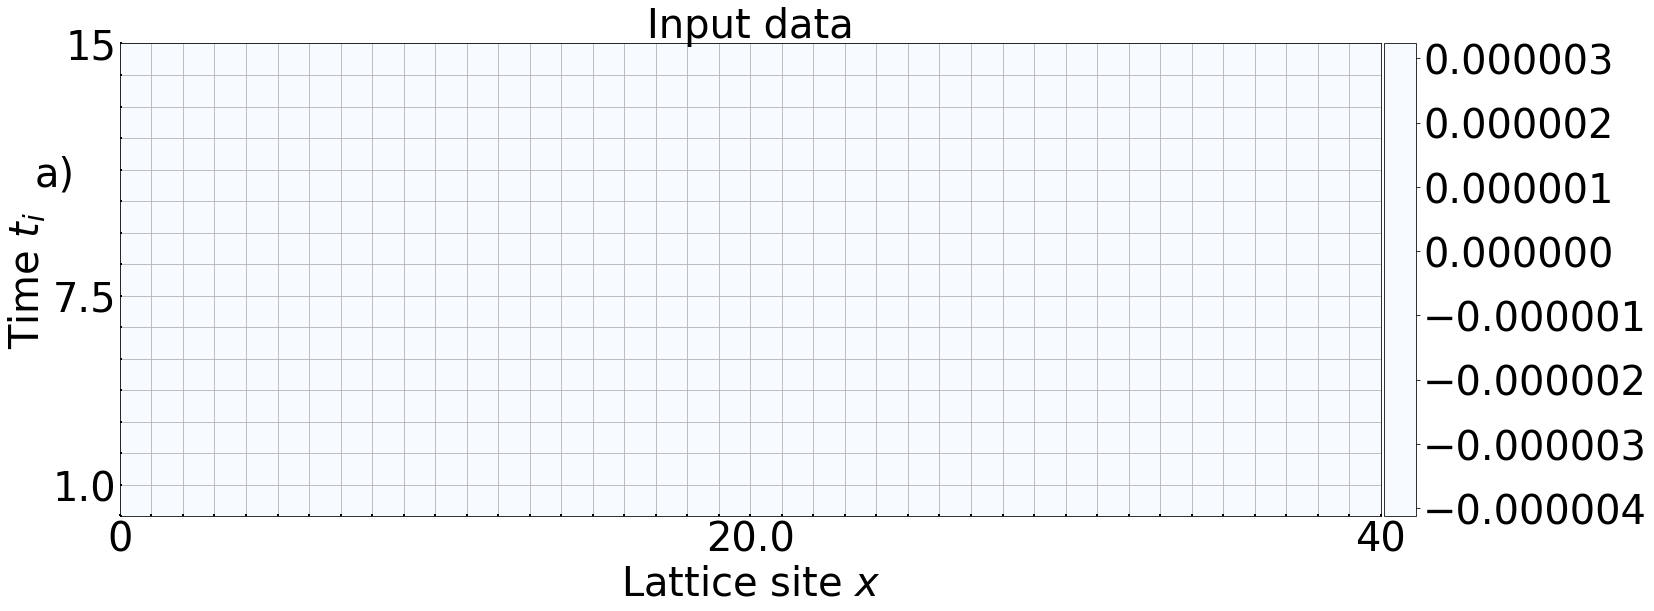

In [8]:
L=40
save_path = 'figs/tomography_double_check_L_'+str(L)+'_T_'+str(T)+'_N_'+str(N)+'_sigma_'+str( int( np.ceil(sigma) ) )+'.pdf'

fontsize = 40
plt.rcParams['axes.labelsize'] = fontsize
plt.rcParams['axes.titlesize'] = fontsize
plt.rcParams['font.size'] = fontsize

#Main plot
fig = plt.figure( figsize = ( 20,20 ) )

data_pos_x  = 0.06
data_pos_y = .49
data_height = 0.4
data_width = 0.9

ini_pos_x  = 0.06
ini_pos_y = .1
ini_height = 0.4
ini_width = ini_height

rec_pos_x  = 0.54
rec_pos_y = .1
rec_height = 0.4
rec_width = rec_height

inset_pos_x = 0.57
inset_pos_y = 0.335   
inset_height = 0.15
inset_width = 0.15

label_a_x = -2.7
label_a_y = 10.5
label_b_x = -5
label_b_y = 51   
label_c_x = -3
label_c_y = 51

## a)
#Input data
ax_input_data = fig.add_axes( [ data_pos_x, data_pos_y, data_width, data_height ] )   


plt.text( label_a_x,label_a_y, 'a)')


im_input_data = ax_input_data.imshow( data2, cmap='Blues', aspect = 'auto', interpolation = None, 
                                     extent= [0, L, N, 0])

title = r'Input data'
plt.title( title )
plt.xlabel( 'Lattice site $x$' )
plt.ylabel( 'Time $t_i$' )
plt.clabel = r'$N_x(t)$'

plt.grid() 

plt.xlim((0,L))
N = len( times )        
plt.ylim((0,N))

xlabels = ['']*(L+1)
xlabels[0]='0'
xlabels[-1]=(L)
xlabels[int(L/2)] =(L/2)
ylabels = ['']*(N+1)
ylabels[1]=T/N
ylabels[-1]=T
ylabels[int(N/2)]= ( (T/2))
#ylabels[5]= ( (T/2))

plt.xticks( range(0,L+1),xlabels )
plt.yticks( range(0,N+1), ylabels)

ax_input_data.tick_params(direction='in', length=2, width=2, colors='k')#,    grid_color='k', grid_alpha=0.5)

divider = make_axes_locatable(ax_input_data)
cax = divider.append_axes("right", size="2.5%", pad=0.05)        
cbar = plt.colorbar(im_input_data, cax=cax)
cbar.set_clim( 0, 1 )
ax_input_data.set_aspect(1)




plt.savefig( save_path, format='pdf')
plt.show()
